## Titanic - Machine Learning from Disaster 

#### Part 1 Imports and Definitions


In [171]:
# import numpy, matplotlib, etc.
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


# sklearn imports
import sklearn
from sklearn import metrics
from sklearn import datasets
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection


# define plt settings
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["legend.title_fontsize"] = 20


# define the input and output folders
input_folder = "input/"
output_folder = "output/"

#### Load the traning data
- print all the contect of the input folder


In [172]:
for dirname, _, filenames in os.walk(input_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))


input/train.csv


In [173]:
train_data = pd.read_csv(input_folder + "train.csv")


- remove the columns that are not needed


In [174]:
train_data = train_data.drop(['PassengerId'], axis=1) 
train_data = train_data.drop(['Name'], axis=1)
train_data = train_data.drop(['Ticket'], axis=1)



- print the head of the train.csv file

In [175]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


Convert Men/Women to 1/0

In [176]:
# Define a dictionary to map 'female' to 0 and 'male' to 1
sex_mapping = {'female': 0, 'male': 1}

# Apply the mapping to the 'Sex' column
train_data['Sex'] = train_data['Sex'].map(sex_mapping)


### Part 2 Data Investigation and Preprocessing


Get summary statistics for the training dataset show only the numerical columns


In [177]:
train_data.describe()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200


Get the number of missing values in the training dataset


In [178]:
display(train_data.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

The dataset contains missing values in the following columns:

- Age: 177 missing values
- Cabin: 687 missing values (cabin has a lot of missing values)
- Embarked: 2 missing values


Get the data types of the columns in the training dataset


In [179]:
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


None

#### Display the features


In [180]:
def plot_and_calculate(df, column):
    # Plot the survival rate
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, hue='Survived', data=df)
    plt.title(f'Survival Rate by {column}')
    plt.show()

    # Group by column and 'Survived', then get the size of each group
    grouped = df.groupby([column, 'Survived']).size()

    # Calculate the percentage of survivors
    percentage_survived = grouped.xs(1, level='Survived') / grouped.groupby(level=column).sum() * 100

    # Print the percentage of survivors
    print(f"Percentage of survivors for each {column}:")
    print(percentage_survived)

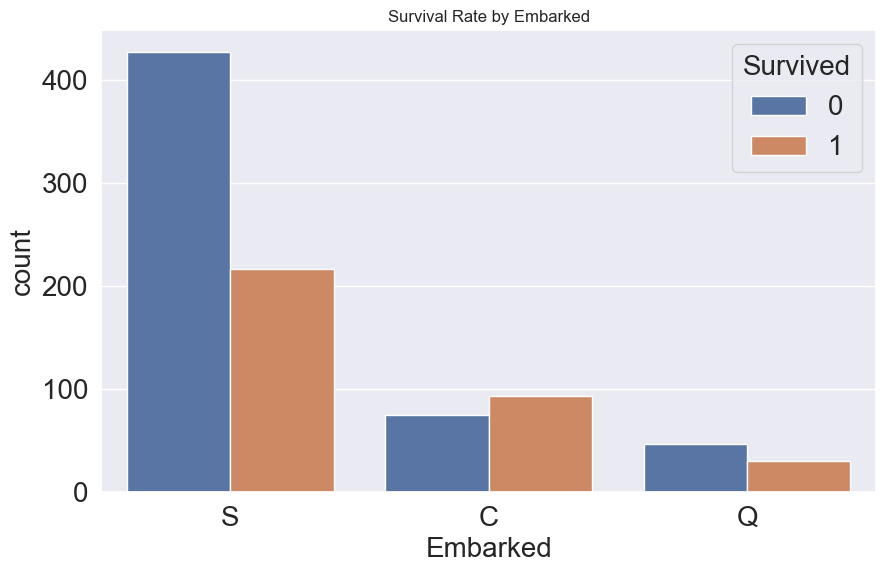

Percentage of survivors for each Embarked:
Embarked
C    55.357143
Q    38.961039
S    33.695652
dtype: float64


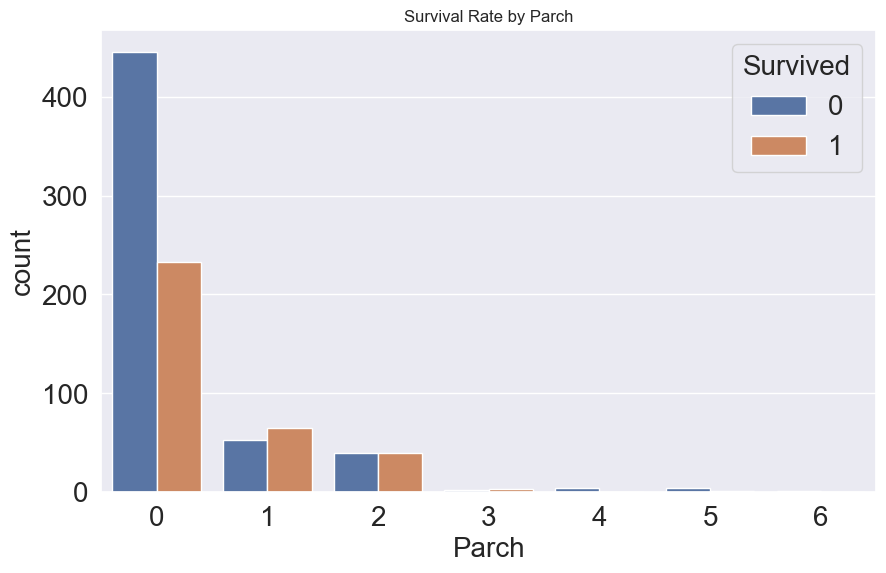

Percentage of survivors for each Parch:
Parch
0    34.365782
1    55.084746
2    50.000000
3    60.000000
4          NaN
5    20.000000
6          NaN
dtype: float64


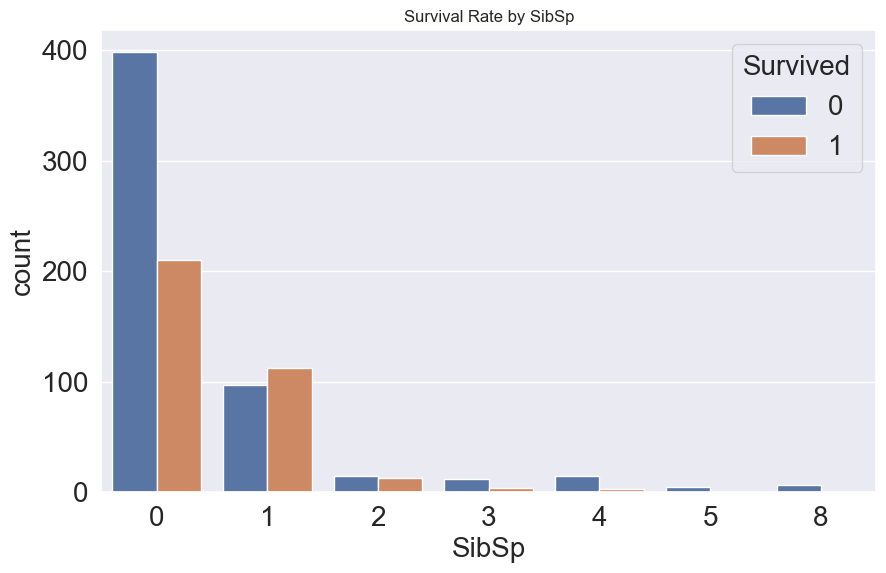

Percentage of survivors for each SibSp:
SibSp
0    34.539474
1    53.588517
2    46.428571
3    25.000000
4    16.666667
5          NaN
8          NaN
dtype: float64


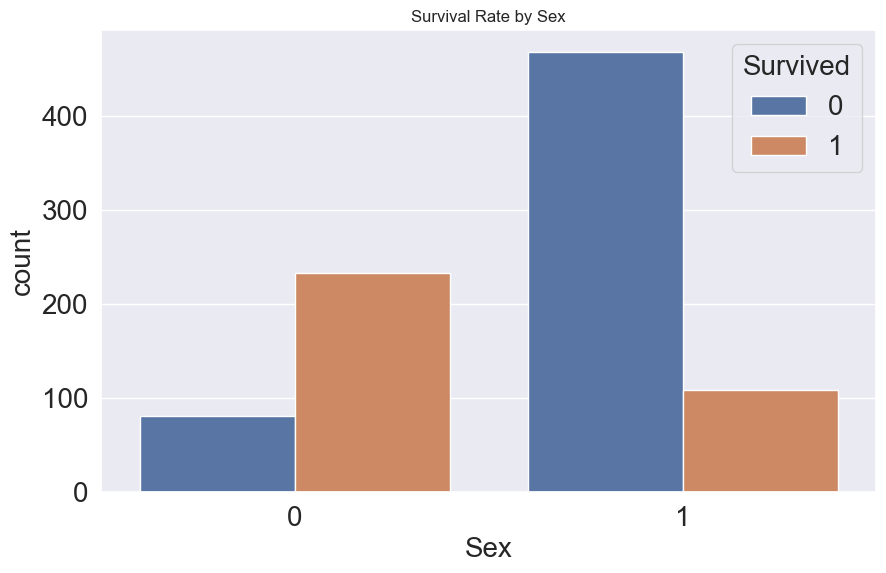

Percentage of survivors for each Sex:
Sex
0    74.203822
1    18.890815
dtype: float64


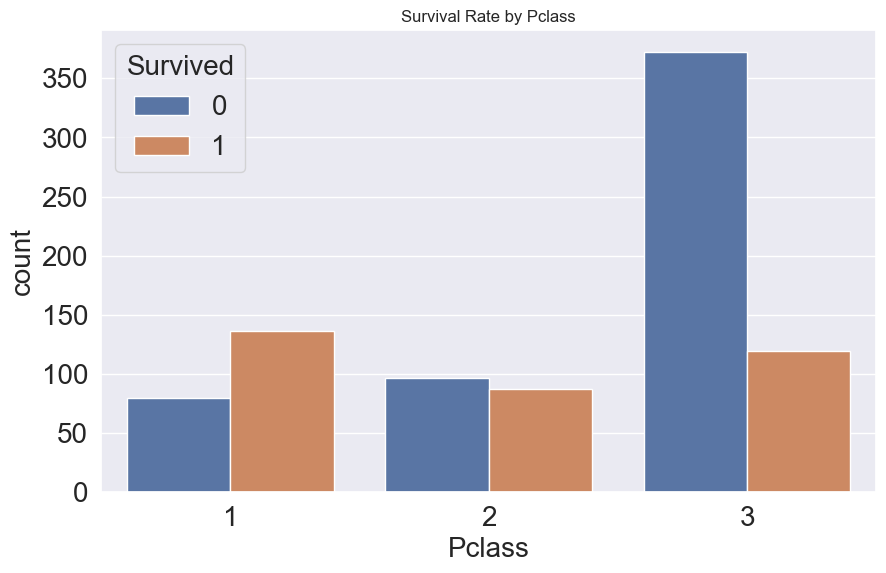

Percentage of survivors for each Pclass:
Pclass
1    62.962963
2    47.282609
3    24.236253
dtype: float64


In [181]:
plot_and_calculate(train_data, 'Embarked')
plot_and_calculate(train_data, 'Parch')
plot_and_calculate(train_data, 'SibSp')
plot_and_calculate(train_data, 'Sex')
plot_and_calculate(train_data, 'Pclass')


**Pairplot Visualizing Correlation**

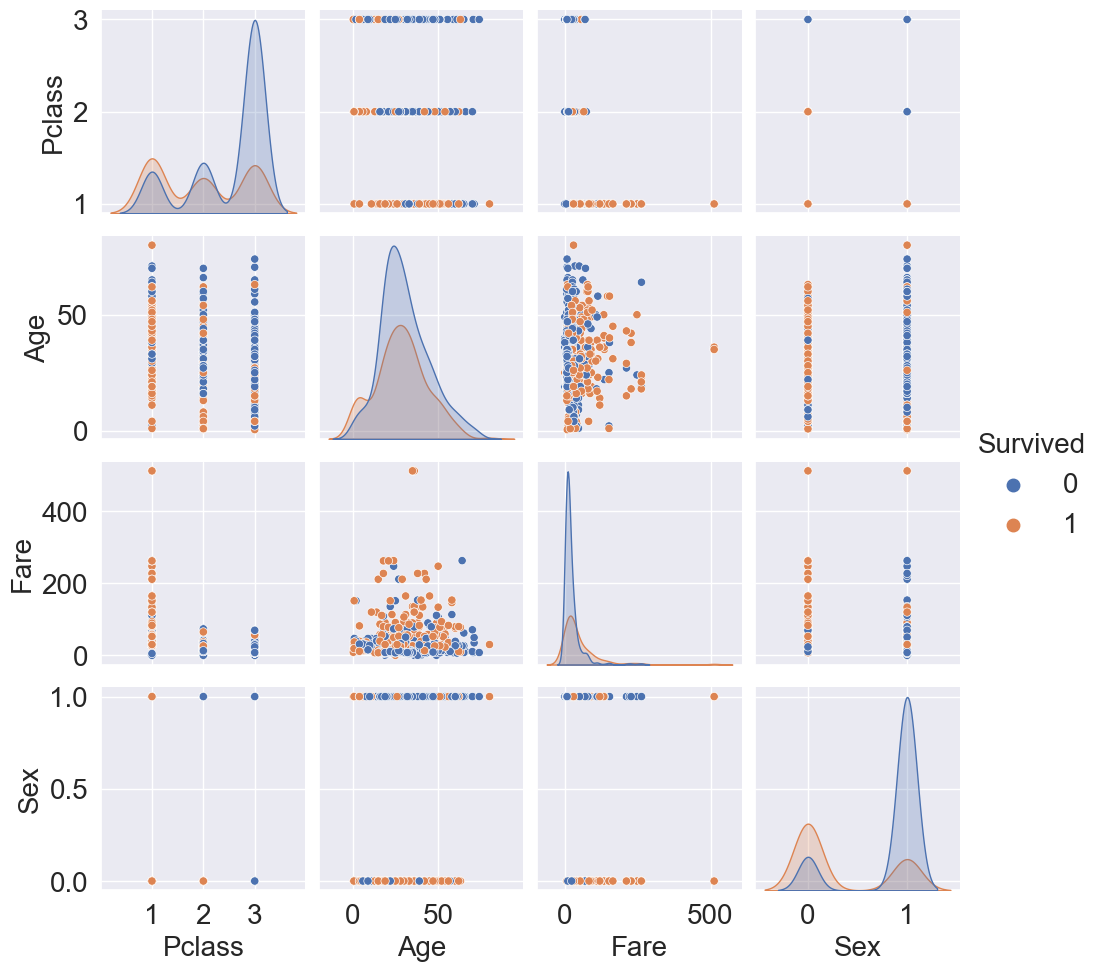

In [182]:
sns.pairplot(train_data[['Survived', 'Pclass', 'Age', 'Fare', 'Sex']], hue='Survived')
plt.show()

**Heatmap for correlation matrix**


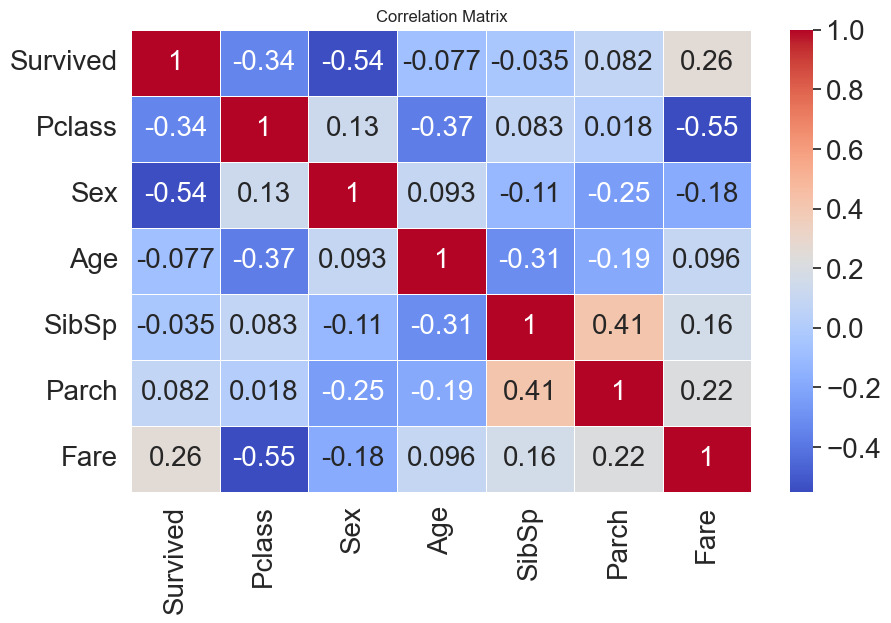

In [183]:
plt.figure(figsize=(10, 6))
corr_matrix = train_data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Part 3 Data Cleaning and Preprocessing